In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from utils import *

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
%load_ext autoreload
%autoreload 2

In [33]:
model_1_data = pd.read_csv('model_1/model_2_data.csv')

In [34]:
cols = ['sk_match_id', 'frame', 'SoF', 'success', 'defender_box_count','player_name', 'pass_recipient_name', 'sk_player_id', 'receive_frame', 'player_1']

In [46]:
model_1_data.shape

(5652, 62)

In [35]:
model_1_data['team'] = model_1_data['team'].apply(lambda x: 1 if x == 'home' else 0)

In [36]:
sampled_df = (
    model_1_data.groupby('sk_match_id', group_keys=False)
      .apply(lambda group: group.sample(frac=0.6, random_state=42))
)

In [37]:
model_df = model_1_data.loc[model_1_data.index.difference(sampled_df.index)]

In [6]:
#model_df = model_1_data.copy()

In [41]:
features = ["score_diff", "SoF", "attacker_count", "defender_count", "team", "defender_box_count"]
target = "success"

In [42]:
model_df = model_df[features+[target]]

In [43]:
model_df.isna().sum()

score_diff            0
SoF                   0
attacker_count        0
defender_count        0
team                  0
defender_box_count    0
success               0
dtype: int64

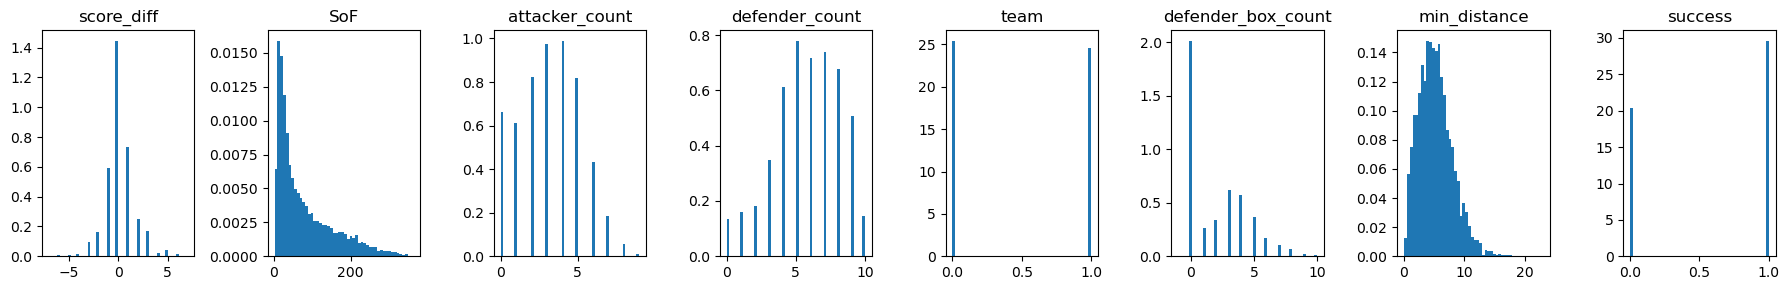

In [110]:
plt.figure(figsize=(18,3))

for i, col in enumerate(features+[target]):
    plt.subplot(1, 8, i+1)
    plt.hist(model_df[col], bins=50, density=True)
    plt.title(col)

plt.tight_layout()
plt.show()

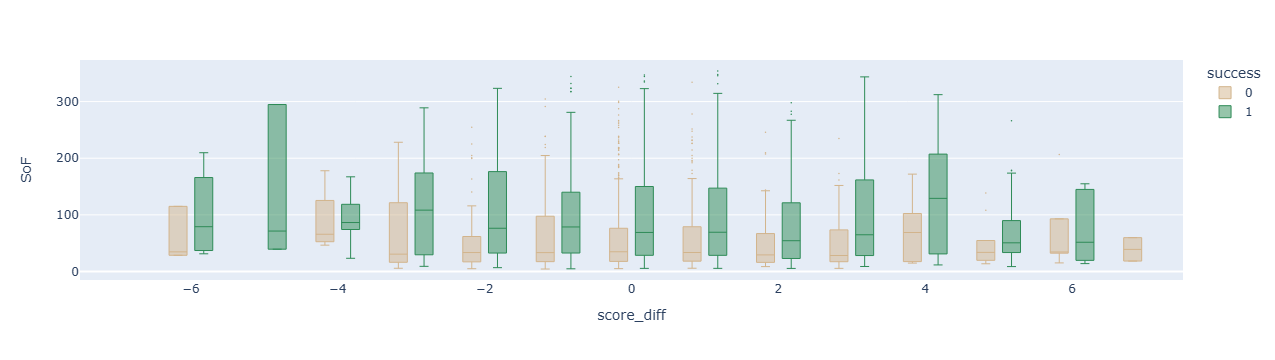

In [34]:
fig = px.box(
    model_df,
    x="score_diff",
    y="SoF",
    color="success",
    color_discrete_map={1: "seagreen", 0: "tan"}  # Map specific colors
)

# Update the quartile method and style
fig.update_traces(
    quartilemethod="exclusive", marker=dict(size=1.5),
    line_width=1  # Remove edge lines
)

# Show the plot
fig.show()

In [43]:
model_df[target].value_counts()

success
1    2050
0    1394
Name: count, dtype: int64

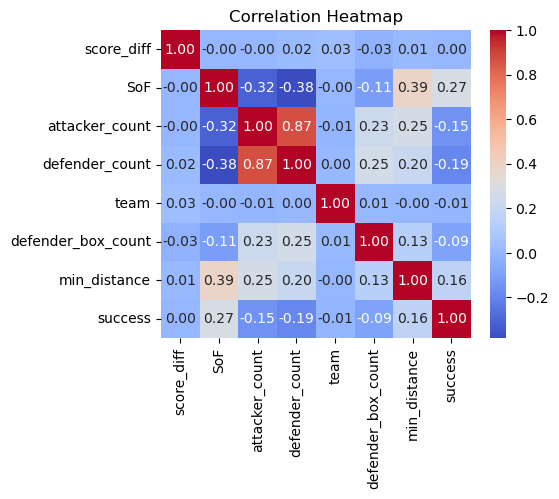

In [128]:
correlation_matrix = model_df[features + [target]].corr()
plt.figure(figsize=(5,4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [44]:
X = model_df[features]
y = model_df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [45]:
models = {
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 150],
            "max_depth": [None, 10, 20],
        },
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 150],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7],
        },
    },
    "LogisticRegression": {
        "model": LogisticRegression(random_state=42, max_iter=500),
        "params": {
            "C": [0.1, 1, 10],
            "penalty": ["l2"],
            "solver": ["liblinear", "lbfgs"],
        },
    },
    "KNeighbors": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"],
        },
    },
    "XGBoost": {
        "model": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"),
        "params": {
            "n_estimators": [50, 100, 150],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7],
        },
    },
}

# Perform GridSearchCV for each model
best_models = {}
for name, entry in models.items():
    print(f"Optimizing {name}...")
    grid = GridSearchCV(entry["model"], entry["params"], cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"Best params for {name}: {grid.best_params_}")
    print(f"Best cross-validated accuracy for {name}: {grid.best_score_:.4f}\n")

# Compare performance on the test set
print("Performance Comparison:")
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")

Optimizing RandomForest...
Best params for RandomForest: {'max_depth': 20, 'n_estimators': 150}
Best cross-validated accuracy for RandomForest: 0.6730

Optimizing GradientBoosting...
Best params for GradientBoosting: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}
Best cross-validated accuracy for GradientBoosting: 0.6545

Optimizing LogisticRegression...
Best params for LogisticRegression: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validated accuracy for LogisticRegression: 0.6179

Optimizing KNeighbors...
Best params for KNeighbors: {'n_neighbors': 5, 'weights': 'distance'}
Best cross-validated accuracy for KNeighbors: 0.6811

Optimizing XGBoost...
Best params for XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Best cross-validated accuracy for XGBoost: 0.6568

Performance Comparison:
Model: RandomForest
Accuracy: 0.6128
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.50  

Feature Importances for RandomForest:
              Feature  Importance
0                 SoF    0.321141
1        min_distance    0.275797
2          score_diff    0.100773
3  defender_box_count    0.096364
4      defender_count    0.093239
5      attacker_count    0.085855
6                team    0.026829


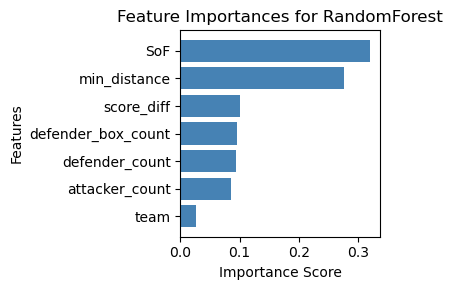

Feature Importances for GradientBoosting:
              Feature  Importance
0                 SoF    0.471029
1        min_distance    0.203620
2  defender_box_count    0.161511
3      defender_count    0.104565
4      attacker_count    0.026451
5          score_diff    0.025925
6                team    0.006899


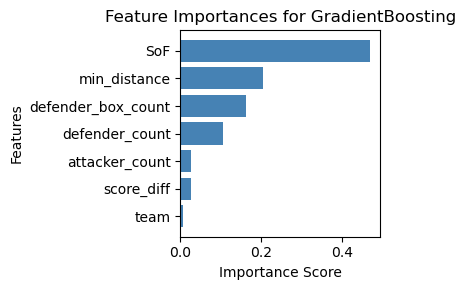

Feature Importances for XGBoost:
              Feature  Importance
0                 SoF    0.395142
1  defender_box_count    0.268823
2      attacker_count    0.092946
3        min_distance    0.080137
4      defender_count    0.068421
5                team    0.052645
6          score_diff    0.041886


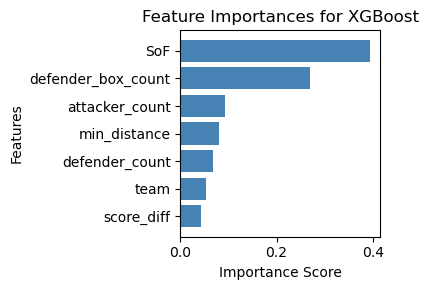

In [182]:
for name, model in best_models.items():
    if hasattr(model, "feature_importances_"):
        print(f"Feature Importances for {name}:")
        
        # Extract feature importance
        feature_importances = model.feature_importances_
        sorted_idx = np.argsort(feature_importances)[::-1]  # Sort in descending order
        
        # Create a DataFrame for better visualization
        importance_df = pd.DataFrame({
            "Feature": X_train.columns[sorted_idx],
            "Importance": feature_importances[sorted_idx],
        })
        
        print(importance_df)
        
        # Plot the feature importance
        plt.figure(figsize=(4, 3))
        plt.barh(
            importance_df["Feature"], 
            importance_df["Importance"], 
            color="steelblue"
        )
        plt.gca().invert_yaxis()  # Reverse the order for better readability
        plt.title(f"Feature Importances for {name}")
        plt.xlabel("Importance Score")
        plt.ylabel("Features")
        plt.tight_layout()
        plt.show()

In [53]:
logistic_model = best_models["LogisticRegression"]

# Prepare the features from sampled_df
X_sampled = sampled_df[X_train.columns]  # Ensure the same features as X_train

# Predict using the Logistic Regression model
sampled_df_predictions = logistic_model.predict(X_sampled)

# Add predictions to sampled_df
sampled_df["predictions"] = sampled_df_predictions

In [67]:
all_counts[all_counts >= 8].index

Index(['C. Kelly', 'C. Foord', 'N. Charles', 'L. Hemp', 'S. Catley', 'B. Mead',
       'M. Fowler', 'Leila Ouahabi', 'E. Toone', 'H. Blundell',
       ...
       'K. Cooney-Cross', 'A. Galli', 'A. Whelan', 'D. Spence', 'F. Nagano',
       'J. Olme', 'S. Nüsken', 'E. Bissell', 'J. Carter', 'S. Ingle'],
      dtype='object', name='pass_recipient_name', length=126)

In [150]:
excellent = sampled_df[(sampled_df['predictions'] == 0) & (sampled_df['success'] == 1)]
difficult_count = len(sampled_df[sampled_df['predictions'] == 0])
all_counts = sampled_df.pass_recipient_name.value_counts()
excellent = excellent[excellent['pass_recipient_name'].isin(all_counts[all_counts >= 10].index)]

In [191]:
excellent[excellent['pass_recipient_name'] == 'E. Morgan'][['sk_match_id', 'possession_team_name', 'receive_frame', 'SoF', 'player_1', 'player_2','receive_x', 'receive_y', 'player_x_1', 'player_y_1', 'player_x_2', 'player_y_2', 'score_1', 'score_2', 'dist_0', 'dist_1', 'dist_2']]

,sk_match_id,possession_team_name,receive_frame,SoF,player_1,player_2,receive_x,receive_y,player_x_1,player_y_1,player_x_2,player_y_2,score_1,score_2,dist_0,dist_1,dist_2
940,1169170,Manchester City,7190.0,68.877867,57072.0,22604.0,25.51,-20.86,26.99,-15.51,45.25,20.81,1,1,34.111577,29.854986,22.036756
974,1169170,Manchester City,19379.0,14.691306,57072.0,64095.0,23.58,-33.80,21.22,-26.00,0.44,-6.55,1,0,44.483777,40.674788,52.470431
1448,1227049,Manchester City,35973.0,12.460152,57072.0,22712.0,-26.86,32.83,-26.46,32.25,-22.49,15.35,0,1,40.455636,40.224173,31.940297
1857,1245010,Manchester City,4939.0,48.334325,57072.0,22684.0,17.58,-27.82,15.60,-17.85,24.16,-14.84,1,1,44.647047,40.990639,31.990330
1879,1245010,Manchester City,14381.0,44.621550,57072.0,63931.0,17.60,-29.50,15.88,-25.37,24.48,-12.37,0,1,45.697484,44.549538,30.629027
3224,1315114,Manchester City,49401.0,29.897873,57072.0,68512.0,25.00,-32.31,27.53,-31.47,30.98,-11.05,1,1,42.428600,40.172899,24.191174
3231,1315114,Manchester City,51386.0,85.525960,57072.0,57068.0,23.04,-21.76,23.02,-21.51,33.48,-14.56,0,1,36.624981,36.493157,23.953163
3233,1315114,Manchester City,52168.0,14.231182,57072.0,57070.0,38.91,-33.81,38.39,-33.80,36.73,-21.13,0,1,36.439048,36.626931,26.366073
3551,1366200,Manchester City,6973.0,24.312720,57072.0,22712.0,-31.26,33.36,-32.05,31.84,-28.42,28.15,0,1,39.547784,37.841619,37.044148
3567,1366200,Manchester City,17714.0,50.446941,57072.0,57068.0,-21.00,24.90,-22.04,24.60,-37.40,29.08,0,1,40.152958,39.153181,32.766697


In [154]:
excellent.pass_recipient_name.value_counts()

pass_recipient_name
C. Kelly              52
C. Foord              36
L. Hemp               27
M. Fowler             27
E. Toone              24
B. Mead               21
N. Charles            20
S. Catley             20
H. Blundell           16
Leila Ouahabi         15
K. Casparij           14
S. Mayling            14
J. Rytting Kaneryd    13
K. Hanson             13
A. Lawrence           13
L. Galton             13
M. Höbinger           13
L. James              13
L. Evans              12
K. Dali               12
A. Leon               12
H. Payne              11
K. Robinson           11
J. Rantala            11
K. Smith              11
G. Reiten             10
C. Lacasse            10
J. Naz                10
J. Roord              10
C. Bott               10
A. Neville             9
G. Clinton             9
K. McCabe              9
Lucía García           9
J. Nobbs               8
È. Périsset            8
Laia Aleixandri        8
Y. Hasegawa            8
R. Shimizu             8
M. Pa

In [151]:
ratio = excellent.pass_recipient_name.value_counts()/difficult_count
ratio[~ratio.isna()].sort_values(ascending = False)

pass_recipient_name
C. Kelly              0.025679
C. Foord              0.017778
L. Hemp               0.013333
M. Fowler             0.013333
E. Toone              0.011852
B. Mead               0.010370
N. Charles            0.009877
S. Catley             0.009877
H. Blundell           0.007901
Leila Ouahabi         0.007407
K. Casparij           0.006914
S. Mayling            0.006914
L. Galton             0.006420
L. James              0.006420
M. Höbinger           0.006420
A. Lawrence           0.006420
J. Rytting Kaneryd    0.006420
K. Hanson             0.006420
L. Evans              0.005926
K. Dali               0.005926
A. Leon               0.005926
H. Payne              0.005432
K. Robinson           0.005432
J. Rantala            0.005432
K. Smith              0.005432
J. Roord              0.004938
C. Bott               0.004938
C. Lacasse            0.004938
J. Naz                0.004938
G. Reiten             0.004938
A. Neville            0.004444
G. Clinton         

In [88]:
top_ten = ratio[~ratio.isna()].sort_values(ascending=False).head(10)
bottom_ten = ratio[~ratio.isna()].sort_values(ascending=False).tail(10)

In [73]:
not_excellent = sampled_df[(sampled_df['predictions'] == 1) & (sampled_df['success'] == 0)]
not_excellent = not_excellent[not_excellent['pass_recipient_name'].isin(all_counts[all_counts >= 10].index)]

In [74]:
not_excellent.shape

(241, 63)

In [77]:
ne_ratio = not_excellent.pass_recipient_name.value_counts()/all_counts
ne_ratio[~ne_ratio.isna()].sort_values(ascending = False)
ne_top_ten = ne_ratio[~ne_ratio.isna()].sort_values(ascending=False).head(10)

In [32]:
top_ten.index

Index(['E. Toone', 'C. Bott', 'M. Höbinger', 'M. Fowler', 'A. Leon',
       'H. Payne', 'S. Mayling', 'L. James', 'J. Rantala', 'J. Naz'],
      dtype='object', name='pass_recipient_name')

In [89]:
top_ten_df = model_1_data[model_1_data['pass_recipient_name'].isin(top_ten.index)]
not_top_ten_df = model_1_data[~model_1_data['pass_recipient_name'].isin(top_ten.index)]

In [85]:
ne_top_ten_df = model_1_data[model_1_data['pass_recipient_name'].isin(ne_top_ten.index)]

In [100]:
rank_df = model_1_data[model_1_data['pass_recipient_name'].isin(all_counts[all_counts >= 10].index)]

In [101]:
rank_df.groupby('pass_recipient_name')['MPD'].median().sort_values(ascending = False)

pass_recipient_name
G. Fisk               4.400966
Tatiana Pinto         3.894426
H. Miyazawa           3.763769
L. Naalsund           3.563878
D. Rose               3.539330
H. Cain               3.492062
J. Ziu                3.453223
J. Naz                3.357851
Y. Hasegawa           3.271412
N. Maritz             3.091076
Vicky Losada          3.056851
A. Harrison           2.929249
E. Cuthbert           2.924414
A. Denton             2.919446
È. Périsset           2.898446
K. Shaw               2.893797
N. Sørensen           2.843724
M. Goodwin            2.831474
Lucía García          2.810427
E. Koivisto           2.795105
F. Morgan             2.769901
Lee Geum-Min          2.719500
H. Blundell           2.717865
A. Greenwood          2.711407
H. Payne              2.709295
J. Matthews           2.706539
H. Hayashi            2.696698
K. Dali               2.671141
J. Nobbs              2.661539
J. Park               2.656364
J. Roord              2.639744
J. Rytting Kaneryd 

In [141]:
model_1_data.pass_recipient_name.value_counts()

pass_recipient_name
C. Kelly               232
C. Foord               173
L. Hemp                151
N. Charles             140
S. Catley              125
B. Mead                113
Leila Ouahabi          103
M. Fowler               97
E. Toone                85
H. Blundell             78
L. Galton               77
C. Bizet Ildhusøy       75
S. Mayling              68
K. Robinson             68
K. Smith                67
K. Hanson               67
K. Dali                 66
J. Rytting Kaneryd      64
C. Lacasse              62
L. James                59
K. Casparij             59
A. Leon                 58
A. Lawrence             55
J. Riviere              53
J. Rantala              53
N. Maritz               53
P. Bremer               52
F. Angeldahl            52
G. Reiten               52
L. Evans                51
H. Payne                51
K. McCabe               50
J. Naz                  50
E. Koivisto             46
J. Park                 46
F. Morgan               46
M. Pache

In [146]:
Toone = model_1_data[model_1_data['pass_recipient_name'] == 'E. Toone']
Hemp = model_1_data[model_1_data['pass_recipient_name'] == 'L. Hemp']

In [147]:
len(Toone), len(Hemp)

(85, 151)

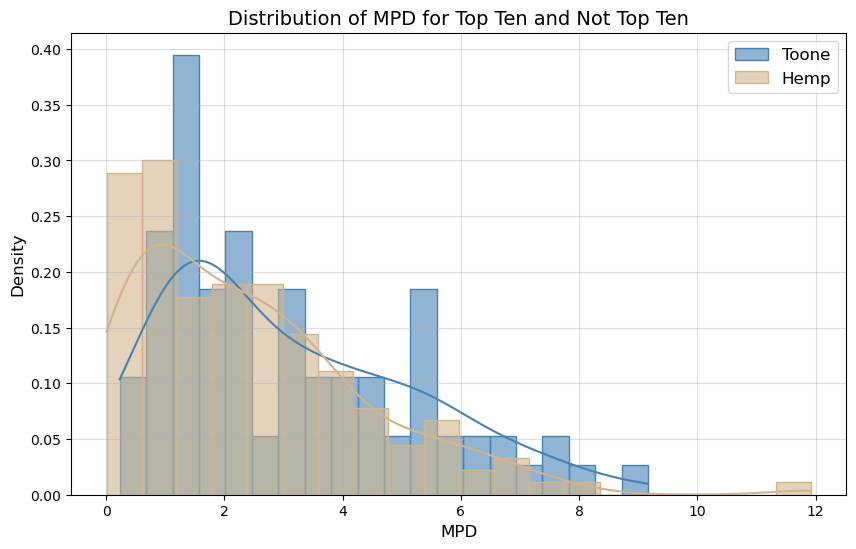

In [149]:
plt.figure(figsize=(10, 6))
sns.histplot(Toone.MPD, kde=True, color="steelblue", label="Toone", stat="density", bins= 20, alpha=0.6, edgecolor='steelblue')
sns.histplot(Hemp.MPD, kde=True, color="tan", label="Hemp", stat="density", bins= 20, alpha=0.6, edgecolor='tan')

# Add labels and legend
plt.title("Distribution of MPD for Top Ten and Not Top Ten", fontsize=14)
plt.xlabel("MPD", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.4)
plt.show()